![Logo 1](img/aitech-logotyp-1.jpg)
<div class="alert alert-block alert-info">
<h1> Widzenie komputerowe </h1>
<h2> 09. <i>Metody głębokiego uczenia (1)</i> [laboratoria]</h2> 
<h3>Andrzej Wójtowicz (2021)</h3>
</div>

![Logo 2](img/aitech-logotyp-2.jpg)

In [10]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/aitech-wko-pub

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/aitech-wko-pub


W poniższym materiale zobaczymy w jaki sposób korzystać z metod głębokiego uczenia sieci neuronowych w pakiecie OpenCV.

Na początku załadujmy niezbędne biblioteki:

In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

OpenCV wspiera [wiele](https://github.com/opencv/opencv/wiki/Deep-Learning-in-OpenCV) bibliotek i modeli sieci neuronowych. Modele trenuje się poza OpenCV - bibliotekę wykorzystuje się tylko do predykcji, aczkolwiek sama w sobie ma całkiem sporo możliwych optymalizacji w porównaniu do źródłowych bibliotek neuronowych, więc predykcja może być tutaj faktycznie szybsza.

Pliki z modelami i danymi pomocniczymi będziemy pobierali z sieci i będziemy je zapisywali w katalogu `dnn`:

In [3]:
!mkdir -p dnn

# Klasyfikacja obrazów

Spróbujemy wykorzystać sieć do klasyfikacji obrazów wyuczonej na zbiorze [ImageNet](https://www.image-net.org/). Pobierzmy plik zawierający opis 1000 możliwych klas:

In [4]:
!wget -q --show-progress -O dnn/classification_classes_ILSVRC2012.txt https://raw.githubusercontent.com/opencv/opencv/master/samples/data/dnn/classification_classes_ILSVRC2012.txt 

dnn/classification_ 100%[===================>]  21.17K  --.-KB/s    in 0.002s  


Spójrzmy na pierwsze pięć klas w pliku:

In [5]:
with open('dnn/classification_classes_ILSVRC2012.txt', 'r') as f_fd:
    classes = f_fd.read().splitlines()
    
print(len(classes), classes[:5])

1000 ['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark']


Do klasyfikacji użyjemy sieci [DenseNet](https://arxiv.org/abs/1608.06993). Pobierzemy jedną z mniejszych [reimplementacji](https://github.com/shicai/DenseNet-Caffe), która jest hostowana m.in. na Google Drive (musimy doinstalować jeden pakiet):

In [6]:
!pip3 install --user --disable-pip-version-check gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import gdown

url = 'https://drive.google.com/uc?id=0B7ubpZO7HnlCcHlfNmJkU2VPelE'
output = 'dnn/DenseNet_121.caffemodel'
gdown.download(url, output, quiet=False)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=0B7ubpZO7HnlCcHlfNmJkU2VPelE 



In [8]:
!wget -q --show-progress -O dnn/DenseNet_121.prototxt https://raw.githubusercontent.com/shicai/DenseNet-Caffe/master/DenseNet_121.prototxt

dnn/DenseNet_121.pr 100%[===================>]  74.68K  --.-KB/s    in 0.01s   


Konkretne biblioteki neuronowe posiadają dedykowane funkcje do ładowania modeli, np. [`readNetFromCaffe()`](https://docs.opencv.org/4.5.3/d6/d0f/group__dnn.html#ga29d0ea5e52b1d1a6c2681e3f7d68473a) lub [`readNetFromTorch()`](https://docs.opencv.org/4.5.3/d6/d0f/group__dnn.html#ga65a1da76cb7d6852bdf7abbd96f19084), jednak można też użyć ogólnej [`readNet()`](https://docs.opencv.org/4.5.3/d6/d0f/group__dnn.html#ga3b34fe7a29494a6a4295c169a7d32422):

In [13]:
model = cv.dnn.readNet(model='dnn/DenseNet_121.prototxt', config='dnn/DenseNet_121.caffemodel', framework='Caffe')

Spróbujemy sklasyfikować poniższy obraz:

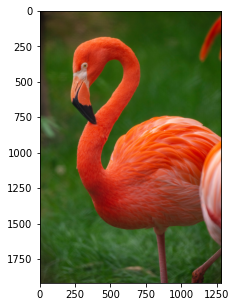

In [14]:
image = cv.imread('img/flamingo.jpg')
plt.figure(figsize=[5,5])
plt.imshow(image[:,:,::-1]);

Aby móc przepuścić obraz przez sieć musimy zmienić jego formę reprezentacji poprzez funkcję [`blobFromImage()`](https://docs.opencv.org/4.5.3/d6/d0f/group__dnn.html#ga29f34df9376379a603acd8df581ac8d7). Aby uzyskać sensowne dane musimy ustawić parametry dotyczące preprocessingu (informacje o tym są zawarte na [stronie modelu](https://github.com/shicai/DenseNet-Caffe)):

In [15]:
image_blob = cv.dnn.blobFromImage(image=image, scalefactor=0.017, size=(224, 224), mean=(104, 117, 123), 
                                  swapRB=False, crop=False)

Ustawiamy dane wejściowe w naszej sieci i pobieramy obliczone wartości:

In [16]:
model.setInput(image_blob)
outputs = model.forward()[0]

Wyliczamy która klasa jest najbardziej prawdopodobna:

In [17]:
outputs = outputs.reshape(1000, 1)

label_id = np.argmax(outputs)

probs = np.exp(outputs) / np.sum(np.exp(outputs))

Wynik:

99.99 %


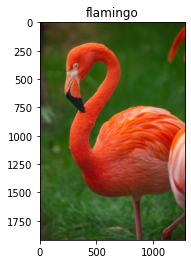

In [18]:
plt.imshow(image[:,:,::-1])
plt.title(classes[label_id])
print("{:.2f} %".format(np.max(probs) * 100.0))

# Wykrywanie twarzy

Do wykrywania twarzy użyjemy sieci bazującej na [SSD](https://github.com/weiliu89/caffe/tree/ssd):

In [19]:
!wget -q --show-progress -O dnn/res10_300x300_ssd_iter_140000_fp16.caffemodel https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel
!wget -q --show-progress -O dnn/res10_300x300_ssd_iter_140000_fp16.prototxt https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt

dnn/res10_300x300_s 100%[===================>]   5.10M  28.5MB/s    in 0.2s    
dnn/res10_300x300_s 100%[===================>]  27.45K  --.-KB/s    in 0.005s  


Ładujemy model:

In [20]:
model = cv.dnn.readNet(model='dnn/res10_300x300_ssd_iter_140000_fp16.prototxt', config='dnn/res10_300x300_ssd_iter_140000_fp16.caffemodel', framework='Caffe')

Będziemy chcieli wykryć twarze na poniższym obrazie:

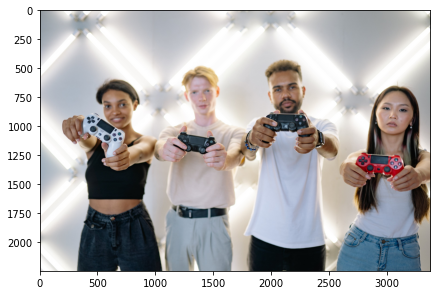

In [21]:
image = cv.imread('img/people.jpg')
plt.figure(figsize=[7,7])
plt.imshow(image[:,:,::-1]);

Znajdujemy twarze i oznaczamy je na zdjęciu (za próg przyjęliśmy 0.5; zob. informacje o [preprocessingu](https://github.com/opencv/opencv/tree/master/samples/dnn#face-detection)):

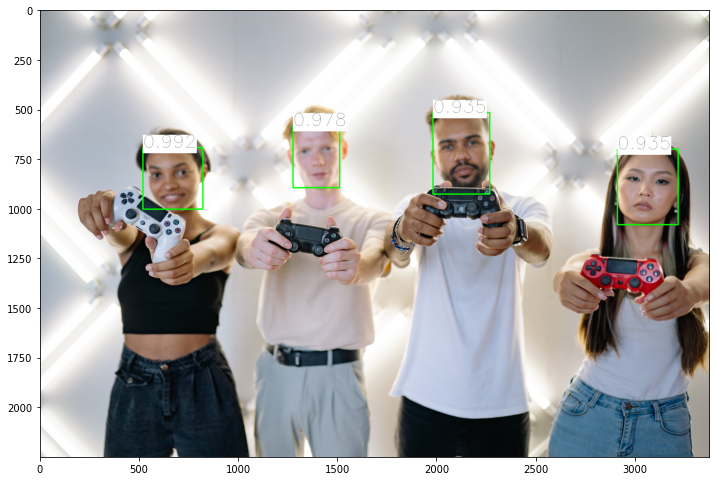

In [22]:
height, width, _ = image.shape

image_blob = cv.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300), mean=[104, 177, 123], 
                                  swapRB=False, crop=False)

model.setInput(image_blob)

detections = model.forward()

image_out = image.copy()

for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:

        box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
        (x1, y1, x2, y2) = box.astype('int')

        cv.rectangle(image_out, (x1, y1), (x2, y2), (0, 255, 0), 6)
        label = '{:.3f}'.format(confidence)
        label_size, base_line = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 3.0, 1)
        cv.rectangle(image_out, (x1, y1 - label_size[1]), (x1 + label_size[0], y1 + base_line), 
                      (255, 255, 255), cv.FILLED)
        cv.putText(image_out, label, (x1, y1), cv.FONT_HERSHEY_SIMPLEX, 3.0, (0, 0, 0))
        
plt.figure(figsize=[12,12])
plt.imshow(image_out[:,:,::-1]);

## Punkty charakterystyczne twarzy

W OpenCV jest możliwość wykrywania punktów charakterystycznych twarzy (ang. *facial landmarks*). Użyjemy zaimplementowanego [modelu](http://www.jiansun.org/papers/CVPR14_FaceAlignment.pdf) podczas Google Summer of Code przy użyciu [`createFacemarkLBF()`](https://docs.opencv.org/4.5.3/d4/d48/namespacecv_1_1face.html#a0bec73a729ed878430c2feb9ce65bc2a):

In [23]:
!wget -q --show-progress -O dnn/lbfmodel.yaml https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml

dnn/lbfmodel.yaml   100%[===================>]  53.76M  54.9MB/s    in 1.0s    


In [24]:
landmark_detector = cv.face.createFacemarkLBF()
landmark_detector.loadModel('dnn/lbfmodel.yaml')

Ograniczamy nasze poszukiwania do twarzy:

In [25]:
faces = []

for detection in detections[0][0]:
    if detection[2] >= 0.5:
        left   = detection[3] * width
        top    = detection[4] * height
        right  = detection[5] * width
        bottom = detection[6] * height

        face_w = right - left
        face_h = bottom - top

        face_roi = (left, top, face_w, face_h)
        faces.append(face_roi)

faces = np.array(faces).astype(int)

_, landmarks_list = landmark_detector.fit(image, faces)

Model generuje 68 punktów charakterycznych, które możemy zwizualizować:

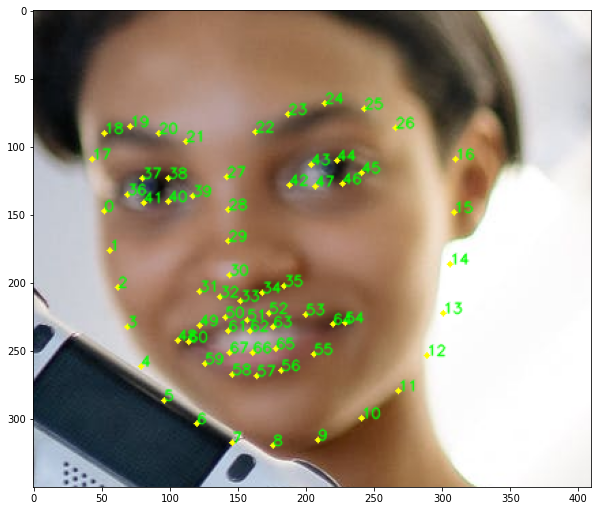

In [26]:
image_display = image.copy()
landmarks = landmarks_list[0][0].astype(int)

for idx, landmark in enumerate(landmarks):
    cv.circle(image_display, landmark, 2, (0,255,255), -1)
    cv.putText(image_display, str(idx), landmark, cv.FONT_HERSHEY_SIMPLEX, 0.35, (0, 255, 0), 1, 
                cv.LINE_AA)

plt.figure(figsize=(10,10))
plt.imshow(image_display[700:1050,500:910,::-1]);

Jeśli nie potrzebujemy numeracji, to możemy użyć prostszego podejścia, tj. funkcji [`drawFacemarks()`](https://docs.opencv.org/4.5.3/db/d7c/group__face.html#ga318d9669d5ed4dfc6ab9fae2715310f5):

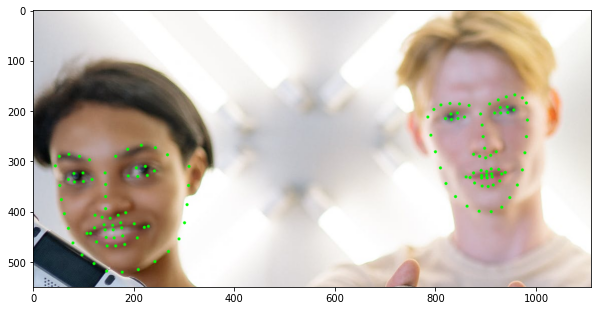

In [27]:
image_display = image.copy()
for landmarks_set in landmarks_list:
    cv.face.drawFacemarks(image_display, landmarks_set, (0, 255, 0))

plt.figure(figsize=(10,10))
plt.imshow(image_display[500:1050,500:1610,::-1]);

# Zadanie 1

W katalogu `vid` znajdują się filmy `blinking-*.mp4`. Napisz program do wykrywania mrugnięć. Opcjonalnie możesz użyć *eye aspect ratio* z [tego artykułu](http://vision.fe.uni-lj.si/cvww2016/proceedings/papers/05.pdf) lub zaproponować własne rozwiązanie.

In [28]:
from scipy.spatial import distance as dist
from imutils.video import FileVideoStream
from imutils.video import VideoStream
from imutils import face_utils
import numpy as np
import argparse
import imutils
import time
import dlib
import cv2

In [29]:
def eye_aspect_ratio(eye):
	A = dist.euclidean(eye[1], eye[5])
	B = dist.euclidean(eye[2], eye[4])
	C = dist.euclidean(eye[0], eye[3])

	ear = (A + B) / (2.0 * C)

	return ear

In [32]:
!wget -q --show-progress -O dnn/shape_predictor_68_face_landmarks.dat https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat

dnn/shape_predictor 100%[===================>]  95.08M  62.0MB/s    in 1.5s    


In [44]:
EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 6

COUNTER = 0
TOTAL = 0

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("dnn/shape_predictor_68_face_landmarks.dat")

(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
print(face_utils.FACIAL_LANDMARKS_IDXS["left_eye"])
print(face_utils.FACIAL_LANDMARKS_IDXS["right_eye"])

(42, 48)
(36, 42)


In [40]:
cap = cv2.VideoCapture("vid/blinking-woman1.mp4")
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter('vid/blinking_woman1_detection.avi', cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))

In [34]:
# vs = FileVideoStream("vid/blinking-woman1.mp4").start()
# fileStream = True
# vs = VideoStream(src=0).start()
# vs = VideoStream(usePiCamera=True).start()
# fileStream = False
# time.sleep(1.0)

cap = cv2.VideoCapture("vid/blinking-woman2.mp4")
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter('vid/blinking_woman2_detection.avi', cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))

In [35]:
for _ in range(n_frames-2):
    ok, frame = cap.read()
    if not ok:
        break
    
    # frame = vs.read()
    # frame = imutils.resize(frame, width=450)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    rects = detector(gray, 0)
    for rect in rects:
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]

        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)

        ear = (leftEAR + rightEAR) / 2.0
        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

        if ear < EYE_AR_THRESH:
            COUNTER += 1
        else:
            if COUNTER >= EYE_AR_CONSEC_FRAMES:
                TOTAL += 1
            
            COUNTER = 0

        cv2.putText(frame, "Blinks: {}".format(TOTAL), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # cv2.imshow("Frame", frame)
    # key = cv2.waitKey(1) & 0xFF

    out.write(frame)

out.release()
cap.release()
# cv2.destroyAllWindows()
# vs.stop()

In [41]:
!ffmpeg -y -hide_banner -loglevel warning -nostats -i vid/blinking_woman1_detection.avi -vcodec libx264 vid/blinking_woman1_detection.mp4

[avi @ 0x5639ad76e000] Format avi detected only with low score of 1, misdetection possible!
vid/blinking_woman1_detection.avi: Invalid data found when processing input


In [37]:
!ffmpeg -y -hide_banner -loglevel warning -nostats -i vid/blinking_woman2_detection.avi -vcodec libx264 vid/blinking_woman2_detection.mp4

In [38]:
import IPython.display

In [42]:
IPython.display.Video("vid/blinking_woman1_detection.mp4", width=800)

ValueError: ignored

In [43]:
IPython.display.Video("vid/blinking_woman2_detection.mp4", width=800)